In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.cluster import KMeans

In [2]:
# Plot settings
cm = plt.get_cmap('gist_rainbow')
line_styles = ['solid', 'dashed', 'dotted']

In [3]:
# Functions
def generateDF(filedir, colnames, sensors, patients, activities, slices):
    # get the data from files for the selected patients
    # and selected activities
    # concatenate all the slices
    # generate a pandas dataframe with an added column: activity
    x = pd.DataFrame()
    for pat in patients:
        for a in activities:
            subdir = 'a' + f"{a:02d}" + '/p' + str(pat) + '/'
            for s in slices:
                filename = filedir + subdir + 's' + f"{s:02d}" + '.txt'
                # print(filename)
                x1 = pd.read_csv(filename, usecols=sensors, names=colnames)
                x1['activity'] = a * np.ones((x1.shape[0],), dtype=int)
                x = pd.concat([x, x1], axis=0, join='outer', ignore_index=True,
                              keys=None, levels=None, names=None, verify_integrity=False,
                              sort=False, copy=True)
    return x


def genFeatures(x, N):
    # the input is the output of generateDF (including the activity name)
    act = x.activity[0]
    y = x.drop(columns=['activity'])
    cols0 = y.columns
    cols1 = cols0 + '_mean'
    cols2 = cols0 + '_std'
    y = y.values  # get the values of dataFrame x
    Nin = y.shape[0]  # number of points in the input dataframe
    Nout = Nin - N  # number of valid points in the output dataframe
    yav_m = np.zeros((Nin, y.shape[1]))
    yav_std = np.zeros((Nin, y.shape[1]))
    for k in range(Nout):
        temp = y[k:k + N, :]  # get the k-th window with N samples
        yav_m[k + N, :] = np.mean(temp, 0)
        yav_std[k + N, :] = np.std(temp, 0)
    yav_m = yav_m[N:, :]
    yav_std = yav_std[N:, :]
    outm_df = pd.DataFrame(yav_m, columns=cols1)
    outs_df = pd.DataFrame(yav_std, columns=cols2)
    out_a = pd.DataFrame(act * np.ones((Nout, 1)), columns=['activity'])
    out_df = pd.concat([outm_df, outs_df, out_a], axis=1)
    return out_df

In [4]:
# Data initialization
filedir = './data/'
sensNames = [
    'T_xacc', 'T_yacc', 'T_zacc',
    'T_xgyro', 'T_ygyro', 'T_zgyro',
    'T_xmag', 'T_ymag', 'T_zmag',
    'RA_xacc', 'RA_yacc', 'RA_zacc',
    'RA_xgyro', 'RA_ygyro', 'RA_zgyro',
    'RA_xmag', 'RA_ymag', 'RA_zmag',
    'LA_xacc', 'LA_yacc', 'LA_zacc',
    'LA_xgyro', 'LA_ygyro', 'LA_zgyro',
    'LA_xmag', 'LA_ymag', 'LA_zmag',
    'RL_xacc', 'RL_yacc', 'RL_zacc',
    'RL_xgyro', 'RL_ygyro', 'RL_zgyro',
    'RL_xmag', 'RL_ymag', 'RL_zmag',
    'LL_xacc', 'LL_yacc', 'LL_zacc',
    'LL_xgyro', 'LL_ygyro', 'LL_zgyro',
    'LL_xmag', 'LL_ymag', 'LL_zmag']
actNames = [
    'sitting',  # 1
    'standing',  # 2
    'lying on back',  # 3
    'lying on right side',  # 4
    'ascending stairs',  # 5
    'descending stairs',  # 6
    'standing in an elevator still',  # 7
    'moving around in an elevator',  # 8
    'walking in a parking lot',  # 9
    'walking on a treadmill with a speed of 4 km/h in flat',  # 10
    'walking on a treadmill with a speed of 4 km/h in 15 deg inclined position',  # 11
    'running on a treadmill with a speed of 8 km/h',  # 12
    'exercising on a stepper',  # 13
    'exercising on a cross trainer',  # 14
    'cycling on an exercise bike in horizontal positions',  # 15
    'cycling on an exercise bike in vertical positions',  # 16
    'rowing',  # 17
    'jumping',  # 18
    'playing basketball'  # 19
]
actNamesShort = [
    'sitting',  # 1
    'standing',  # 2
    'lying.ba',  # 3
    'lying.ri',  # 4
    'asc.sta',  # 5
    'desc.sta',  # 6
    'stand.elev',  # 7
    'mov.elev',  # 8
    'walk.park',  # 9
    'walk.4.fl',  # 10
    'walk.4.15',  # 11
    'run.8',  # 12
    'exer.step',  # 13
    'exer.train',  # 14
    'cycl.hor',  # 15
    'cycl.ver',  # 16
    'rowing',  # 17
    'jumping',  # 18
    'play.bb'  # 19
]

In [5]:
# Indices generation
ind_acc = [i for i in range(45) if 'acc' in sensNames[i]]  # accelerometers
ind_mag = [i for i in range(45) if 'mag' in sensNames[i]]  # magnetometers
ind_gyr = [i for i in range(45) if 'gyr' in sensNames[i]]  # gyroscopes
sensors1 = ind_acc + ind_mag + ind_gyr
sensorsT = [i for i in sensors1 if 'T' in sensNames[i]]  # sensors on torso
sensorsLL = [i for i in sensors1 if 'LL' in sensNames[i]]  # sensors on left leg
sensorsLA = [i for i in sensors1 if 'LA' in sensNames[i]]  # sensors on left arm
sensorsRL = [i for i in sensors1 if 'RL' in sensNames[i]]  # sensors on right leg
sensorsRA = [i for i in sensors1 if 'RA' in sensNames[i]]  # sensors on right arm
sensors = sensorsT  # +sensorsRA+sensorsLL # selected sensors

In [6]:
# (sort of) Control plane
patients = [5]  # list of selected patients
NAc = 19  # total number of activities
activities = list(range(1, 20))  # list of indexes of activities to plot
# Num_activities = len(activities)
actNamesSub = [actNamesShort[i - 1] for i in activities]  # short names of the selected activities

sensNamesSub = [sensNames[i] for i in sensors]  # names of selected sensors
Nslices = 12  # number of slices to plot and to train the system
slices = list(range(1, Nslices + 1))  # first Nslices to plot
NtotSlices = 60  # total number of slices
fs = 25  # Hz, sampling frequency
samplesPerSecond = fs  # samples in one second
samplesPerSlice = fs * 5  # samples in each slice
memory = 4 * samplesPerSecond

In [7]:
save_plots = False
if save_plots:
    for i in activities:
        activ = [i]
        x = generateDF(filedir, sensNamesSub, sensors, patients, activ, slices)
        x = genFeatures(x, memory)
        x = x.drop(columns=['activity'])
        sensor_names = list(x.columns)
        data = x.values
        plt.figure(figsize=(6, 6))
        time = np.arange(data.shape[0]) / fs  # set the time axis
        for k in range(len(sensor_names)):
            lines = plt.plot(time, data[:, k], '.', label=sensor_names[k], markersize=1)
            lines[0].set_color(cm(k // 3 * 3 / len(sensor_names)))
            lines[0].set_linestyle(line_styles[k % 3])
        plt.legend(bbox_to_anchor=(1.04, 1), loc="upper left")
        plt.grid()
        plt.xlabel('time (s)')
        plt.tight_layout()
        plt.title(actNames[i - 1])
        plt.subplots_adjust(top=0.9)
        plt.savefig('./Plot_' + actNamesSub[i - 1] + '.png')

Number of used sensors:  9


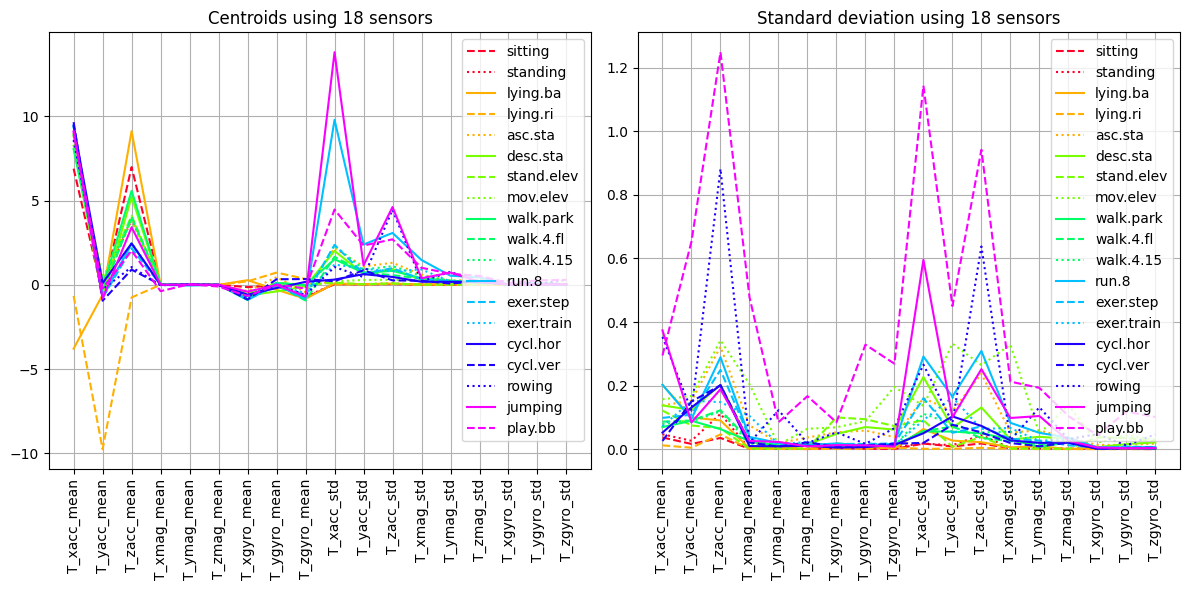

In [8]:
# Centroids generation
plot_results = True
print('Number of used sensors: ', len(sensors))
centroids = np.zeros((NAc, len(sensors) * 2))  # centroids for all the activities
stdpoints = np.zeros((NAc, len(sensors) * 2))  # variance in cluster for each sensor
if plot_results:
    plt.figure(figsize=(12, 6))
for i in range(1, NAc + 1):
    activ = [i]
    x = generateDF(filedir, sensNamesSub, sensors, patients, activ, slices)
    x = genFeatures(x, memory)
    x = x.drop(columns=['activity'])
    sensor_names = list(x.columns)
    centroids[i - 1, :] = x.mean().values
    stdpoints[i - 1] = np.sqrt(x.var().values)
    if plot_results:
        plt.subplot(1, 2, 1)
        lines = plt.plot(centroids[i - 1, :], label=actNamesShort[i - 1])
        lines[0].set_color(cm(i // 3 * 3 / NAc))
        lines[0].set_linestyle(line_styles[i % 3])
        plt.subplot(1, 2, 2)
        lines = plt.plot(stdpoints[i - 1, :], label=actNamesShort[i - 1])
        lines[0].set_color(cm(i // 3 * 3 / NAc))
        lines[0].set_linestyle(line_styles[i % 3])
if plot_results:
    plt.subplot(1, 2, 1)
    plt.legend(loc='upper right')
    plt.grid()
    plt.title('Centroids using ' + str(len(sensor_names)) + ' sensors')
    plt.xticks(np.arange(x.shape[1]), list(x.columns), rotation=90)
    plt.subplot(1, 2, 2)
    plt.legend(loc='upper right')
    plt.grid()
    plt.title('Standard deviation using ' + str(len(sensor_names)) + ' sensors')
    plt.xticks(np.arange(x.shape[1]), list(x.columns), rotation=90)
    plt.tight_layout()

In [9]:
# Computing distances between centroids
plot_results = False
d = np.zeros((NAc, NAc))
for i in range(NAc):
    for j in range(NAc):
        d[i, j] = np.linalg.norm(centroids[i] - centroids[j])
if plot_results:
    plt.figure(figsize=(12, 10))
    plt.matshow(d, fignum=0)
    plt.gca().xaxis.tick_bottom()
    plt.colorbar()
    plt.xticks(np.arange(NAc), actNamesShort, rotation=90)
    plt.yticks(np.arange(NAc), actNamesShort)
    plt.subplots_adjust(bottom=0.2)
    plt.title('Between-centroids distance')

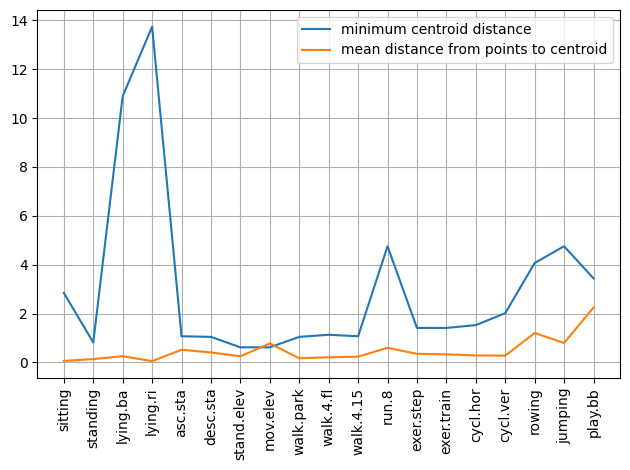

In [10]:
# Comparing minimum distance between two centroids and mean distance from a cluster point
# and its centroid
dd = d + np.eye(NAc) * 1e6  # remove zeros on the diagonal (distance of centroid from itself)
dmin = dd.min(axis=0)  # find the minimum distance for each centroid
dpoints = np.sqrt(np.sum(stdpoints ** 2, axis=1))
plt.figure()
plt.plot(dmin, label='minimum centroid distance')
plt.plot(dpoints, label='mean distance from points to centroid')
plt.grid()
plt.xticks(np.arange(NAc), actNamesShort, rotation=90)
plt.legend()
plt.tight_layout()
plt.show()
# if the minimum distance is less than the mean distance, then some points of the cluster are closer 
# to another centroid

In [11]:
# Generating the training and test datasets by concatenating data for each activity
slicesTrain = list(range(1, Nslices + 1))  # slices for the training part
slicesTest = list(range(Nslices + 1, NtotSlices + 1))  # first for the test part
Ntrain = Nslices * samplesPerSlice
Ntest = (NtotSlices - Nslices) * samplesPerSlice
dataTrain = np.empty((0, len(sensors) * 2), float)
dataTest = np.empty((0, len(sensors) * 2), float)
labelTrain = np.empty((0,), float)
labelTest = np.empty((0,), float)
for i in range(1, NAc + 1):
    activ = [i]
    x = generateDF(filedir, sensNamesSub, sensors, patients, activ, slicesTrain)
    x = genFeatures(x, memory)
    labels = x.activity.values
    x = x.drop(columns=['activity'])
    data = x.values
    dataTrain = np.vstack((dataTrain, data))
    labelTrain = np.hstack((labelTrain, labels))
    x = generateDF(filedir, sensNamesSub, sensors, patients, activ, slicesTest)
    x = genFeatures(x, memory)
    labels = x.activity.values
    x = x.drop(columns=['activity'])
    data = x.values
    dataTest = np.vstack((dataTest, data))
    labelTest = np.hstack((labelTest, labels))

In [12]:
# Using K-Means
labsTrue = np.unique(labelTrain)
Nclu = len(labsTrue)
clu = KMeans(n_clusters=Nclu, init='k-means++', n_init=10,
             max_iter=300, tol=0.0001, verbose=0,
             random_state=1, copy_x=True)
clu.fit(dataTrain)

KMeans(n_clusters=19, n_init=10, random_state=1)

In [17]:
# Prediction
labCluTrain = clu.labels_
labsClu = np.unique(labCluTrain)
labCluTest = clu.predict(dataTest)

In [48]:
# Adjusting K-Means index results
# 
def explore_sol(mapping, labels_priority, label, X, y, y_hat):
    None
    

def evaluate_mapping(mapping, predict_count, labels_count):
    return 1


def adjust_labels(X, y, y_hat):
    label_values = np.unique(y_hat)
    predict_count = np.unique(y_hat, return_counts=True)
    labels_count = np.unique(y, return_counts=True)
    # relative_accuracy = np.divide(np.abs(predict_count - labels_count), labels_count)
    labels_priority = label_values[np.argsort(labels_count[1])]
    best_mapping = np.array([label_values.copy(), label_values.copy()])
    best_score = 1
    for i in range(len(labels_priority)):
        mapping = np.array([label_values.copy(), label_values.copy()])
        explore_sol(mapping, labels_priority, i, X, y, y_hat)
        # computing mapping accuracy
        score = evaluate_mapping(mapping, predict_count, labels_count)
        if score < best_score:
            best_score = score
            best_mapping = mapping

[ 1.  1.  1. ... 19. 19. 19.] [ 7  7  7 ... 14 14 14]
(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18]), array([ 5907,  5900,  5900,  5900, 15566, 11800,  6065,  5900,   591,
        4015,  1050,  5902,  2000,  9618,  2884,  6138,  1784,  9280,
        5900], dtype=int64))


TypeError: tuple indices must be integers or slices, not tuple

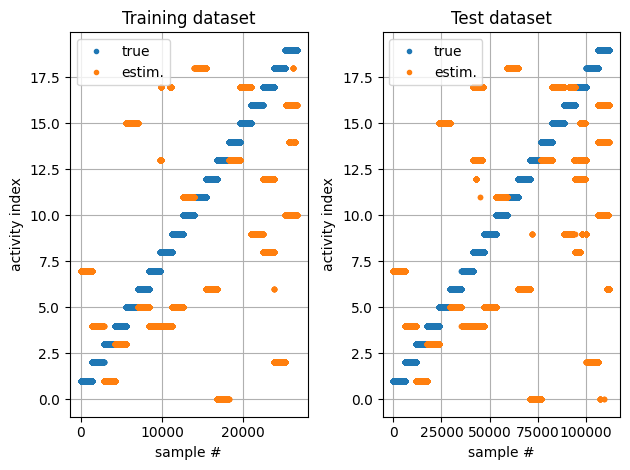

In [42]:
# Printing results
plt.figure()
plt.subplot(1, 2, 1)
plt.plot(labelTrain, '.', label='true')
plt.plot(labCluTrain, '.', label='estim.')
plt.title('Training dataset')
plt.legend()
plt.grid()
plt.xlabel('sample #')
plt.ylabel('activity index')
plt.subplot(1, 2, 2)
plt.plot(labelTest, '.', label='true')
plt.plot(labCluTest, '.', label='estim.')
plt.title('Test dataset')
plt.legend()
plt.grid()
plt.xlabel('sample #')
plt.ylabel('activity index')
plt.tight_layout()
plt.show()